In [1]:
import numpy as np
import Derivatives as Div
from Cheb import Grid
import Solver as Sol
import Plotting 
import Data
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

np.set_printoptions(linewidth=200)

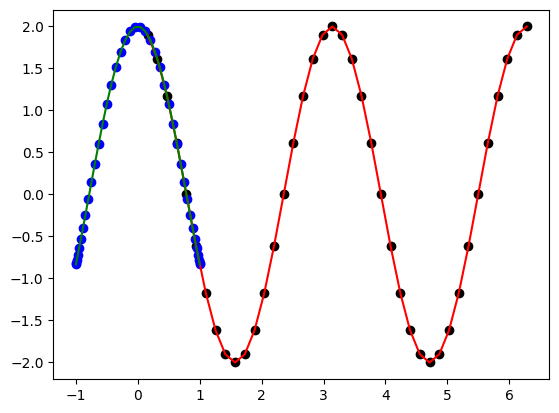

In [2]:
def sin(x, a, b, c, d):
    return a * np.sin(b*x + c)

def sinDiv(x, a, b, c, d):
    return a*b * np.cos(b*x + c)

N = 40
xUni = Grid(N, mode='uni').grid
DUni = Div.DTheta(N).matrix
xCheb = Grid(N, mode="cheb").grid
DCheb = Div.DR(N).matrix    

a, b, c, d = 1, 2, 0, 4

ydataUni = [sin(i, a, b, c, d) for i in xUni]   # 3rd degree polynomial values
ydataCheb = [sin(i, a, b, c, d) for i in xCheb]   
yRefUni = [sinDiv(i, a, b, c, d) for i in xUni] # true derivative
yRefCheb = [sinDiv(i, a, b, c, d) for i in xCheb]
yDUni = DUni.dot(ydataUni)                            # spectral derivative
yDCheb = DCheb.dot(ydataCheb)

# test for uniform grid ranging from 0 to 2*pi
plt.plot(xUni, yRefUni, 'r')
plt.scatter(xUni, yDUni, c='black')

# test for Chebyshev grid ranging from -1 to 1
plt.plot(xCheb, yRefCheb, 'g')
plt.scatter(xCheb, yDCheb, c='blue')

plt.show()

Lattice size:  35
Size after boundary conditions:  (1089, 1089)


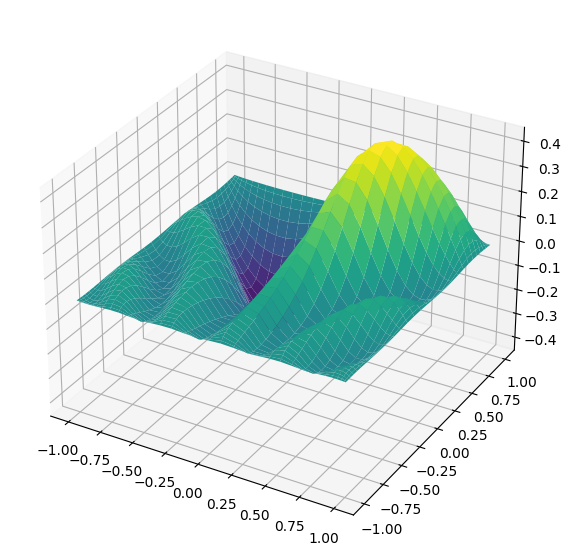

In [3]:
# 2D examples: Poisson and Helmholtz equations

# Data:
solver = Sol.SpectralSolverCart2D()
N = 35
dim = N-2
k = 9
x, y = Grid(N).grid[1:-1], Grid(N).grid[1:-1]
D = Div.DR2(N).matrix[1:-1, 1:-1]

# Helmholtz equation, source 
# L = np.kron(np.identity(dim), D) + np.kron(D, np.identity(dim)) + k*k * np.identity(dim**2)
# source = np.exp(np.kron(np.ones(dim), -10*(y-1)**2) + np.kron(-10*(x-0.5)**2, np.ones(dim)))

# Poisson equation, source and solution
L = np.kron(np.identity(dim), D) + np.kron(D, np.identity(dim))
L = Div.Laplacian(Grid(N), Grid(N), mode='cartesian2D').matrix        # equivalent laplacian, encapsulated in class

source = 10*np.sin(np.kron(8*x, y-1))
sol = solver.solve(L, source)

print("Lattice size: ", N)
print("Size after boundary conditions: ", L.shape)
# print("L rank: ", np.linalg.matrix_rank(L))


Plotting.CartesianPlotter2D().plot(x, y, sol)


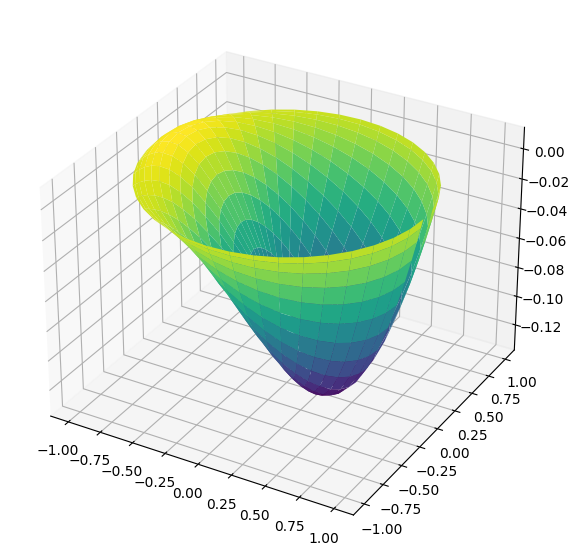

In [4]:
# use trick with mirroring radial grid - requires modification to differentiation matrix
NR, NTheta = 32, 40
dimR = NR-2
# r = Grid(NR, mode="cheb").grid[NR//2:-1]
r = Grid(NR, mode="cheb").grid[1:NR//2]
t = Grid(NTheta, mode="uni").grid
D = Div.DR2(NR).matrix[1:-1, 1:-1]
E = Div.DR(NR).matrix[1:-1, 1:-1]
T = Div.DTheta2(NTheta).matrix
R = np.diag(1/r)
# ------------------------------------------
# Direct approach to writing an operator

d1, d2 = D[:dimR//2, :dimR//2], D[:dimR//2, dimR//2:]
e1, e2 = E[:dimR//2, :dimR//2], E[:dimR//2, dimR//2:]

diagId = Data.DiagId(NTheta).matrix
antiDiagId = Data.AntiDiagId(NTheta).matrix

operator = np.kron(d1 + (R @ e1), diagId) + np.kron(d2 + (R @ e2), antiDiagId) + np.kron(R @ R, T)

# ------------------------------------------
# Automated approach via blockSymmetrize function (abstracts away extracting blocks from differentiation matrices)

D = Div.DR2(NR).matrix
DBlock = Div.blockSymmetrize(D, NTheta)

R = np.diag(1/(Grid(NR).grid[:NR//2]))
E = Div.DR(NR).matrix
RE = np.kron(np.identity(2), R) @ E
EBlock = Div.blockSymmetrize(RE, NTheta)
R = R[1:, 1:]

operator = DBlock + EBlock + np.kron(R @ R, T)
operator = Div.Laplacian(Grid(NR), Grid(NTheta, mode='uni') , mode="polar2D").matrix
# ------------------------------------------

# source = np.kron(-1*r*r, np.sin(t/2)**4) + np.kron(np.ones(len(r)), np.sin(6*t) * np.cos(t/2)**2)
source = np.kron(-1*r*r, np.sin(t/2)**4) + np.kron(np.ones(len(r)), np.cos(t/2)**2)
sol = np.linalg.solve(operator, source)

# print("Operator Rank: ", np.linalg.matrix_rank(operator))


# Create the mesh in polar coordinates and compute corresponding Z.
plotter = Plotting.PolarPlotter()
plotter.plot(r, t, sol, colormap='viridis', zrange=(None, None))  # r, t, sol are 1D vectors, plotter handles reshaping 

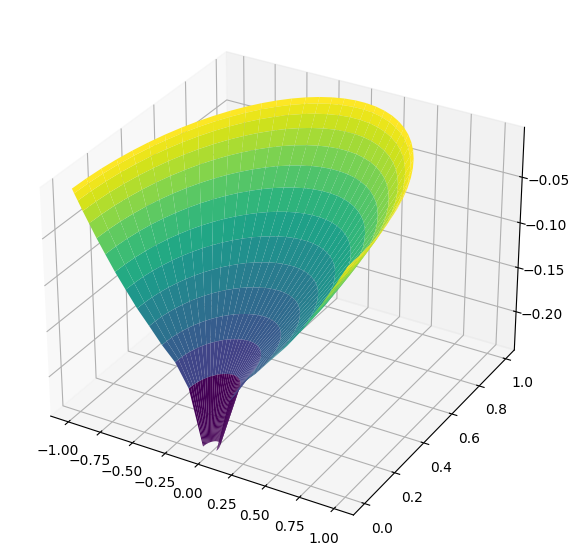

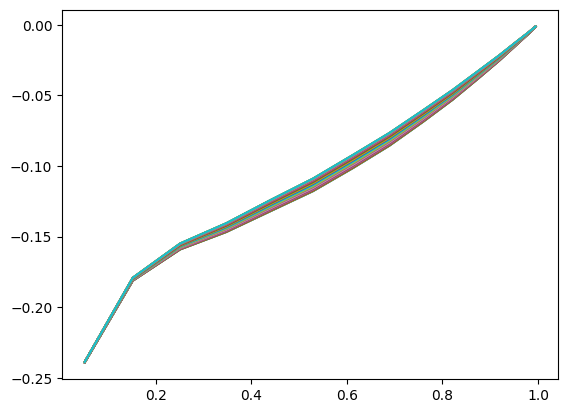

In [5]:
# Test of Laplacian in spherical coordinates
# dimensions and double chebyshev grids
NR, NTheta = 32, 40
r = Grid(NR, mode='cheb').grid[1:NR//2]
t = Grid(NTheta, mode="cheb").grid
print()
# set up equation op.sol = source
operator = Div.Laplacian(Grid(NR), Grid(NTheta, mode="cheb") , mode="spherical").matrix
source = np.kron(-1*r*r, np.sin(t/2)**4) + np.kron(np.ones(len(r)),  np.cos(t/2)**2)
sol = np.linalg.solve(operator, source)

# plot mesh
Plotting.PolarPlotter().plot(r, t, sol)

# Plot slices
y = sol.reshape((operator.shape[0]//NTheta, NTheta))
plt.plot(r, y)
plt.show()

In [8]:
import Utils

grid = Grid(6)
dx = Div.DR(4)

print(Utils.strip(grid.grid))


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed